In [1]:
import xgboost as xgb
import pandas as pd
import sklearn
import numpy as np
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import asarray
from xgboost import XGBRegressor
from pandas import DataFrame
from pandas import concat

In [2]:
# import MSFT data
path=("MSFT_prices_1m.csv")
msft=pd.read_csv(path, index_col="Datetime", parse_dates=True, infer_datetime_format=True)
msft=msft.drop(columns=['Adj Close', 'Volume'])
msft

,Open,High,Low,Close
Datetime,,,,
2022-01-07 09:30:00-05:00,314.15,315.00,313.55,314.52
2022-01-07 09:31:00-05:00,314.51,315.32,314.33,315.24
2022-01-07 09:32:00-05:00,315.24,315.28,314.06,314.66
2022-01-07 09:33:00-05:00,313.50,313.68,313.27,313.56
2022-01-07 09:34:00-05:00,313.54,314.14,313.26,313.47
...,...,...,...,...
2022-01-18 15:56:00-05:00,302.20,302.40,302.06,302.23
2022-01-18 15:57:00-05:00,302.21,302.82,302.17,302.63
2022-01-18 15:58:00-05:00,302.54,302.69,302.42,302.60


In [3]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [4]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>actual=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

In [5]:
# create train/test data split
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [6]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

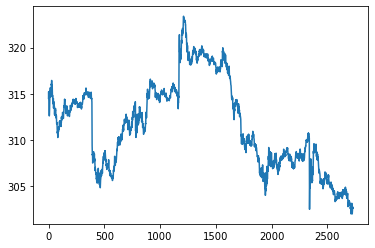

In [7]:
# load MSFT dataset
series = msft.Close
values = series.values
# plot MSFT dataset to show trends
pyplot.plot(values)
pyplot.show()

In [8]:
# transform MSFT values
values.reshape(-1, 1)
values=values.tolist()
values

[314.52,
 315.24,
 314.66,
 313.56,
 313.47,
 313.2,
 312.63,
 312.62,
 312.75,
 313.13,
 313.73,
 314.29,
 314.3,
 315.31,
 314.9,
 315.3,
 315.66,
 315.25,
 315.1,
 314.67,
 314.86,
 314.9,
 315.45,
 315.21,
 315.38,
 316.07,
 315.94,
 316.25,
 316.45,
 315.67,
 315.56,
 315.89,
 316.0,
 315.81,
 315.17,
 314.69,
 314.84,
 314.31,
 314.19,
 313.93,
 313.99,
 314.01,
 314.42,
 314.52,
 314.23,
 313.46,
 313.71,
 314.15,
 313.89,
 313.72,
 313.65,
 313.58,
 313.68,
 313.32,
 312.76,
 313.19,
 313.24,
 312.93,
 312.66,
 312.82,
 313.19,
 313.13,
 313.43,
 313.21,
 313.22,
 312.95,
 312.6,
 312.73,
 312.53,
 312.38,
 312.66,
 312.23,
 311.95,
 311.74,
 311.84,
 311.88,
 311.77,
 311.32,
 311.23,
 310.75,
 310.89,
 310.94,
 310.3,
 310.28,
 310.31,
 310.68,
 310.96,
 311.11,
 310.95,
 310.91,
 311.19,
 311.45,
 311.32,
 311.12,
 311.18,
 311.33,
 311.49,
 311.8,
 312.01,
 311.87,
 311.67,
 311.67,
 312.06,
 311.96,
 312.05,
 312.09,
 311.75,
 311.55,
 311.68,
 311.5,
 311.54,
 311.47,
 31

In [9]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)

>actual=302.4, predicted=302.6
>actual=302.1, predicted=302.6
>actual=302.2, predicted=302.1
>actual=302.0, predicted=302.1
>actual=302.4, predicted=302.1
>actual=302.4, predicted=302.0
>actual=302.5, predicted=302.5
>actual=302.3, predicted=302.5
>actual=302.5, predicted=302.2
>actual=303.2, predicted=302.3
>actual=302.6, predicted=302.5
>actual=302.6, predicted=302.4
>actual=302.8, predicted=303.0
>actual=302.0, predicted=302.4
>actual=302.2, predicted=302.4
>actual=302.2, predicted=302.4
>actual=302.6, predicted=302.1
>actual=302.6, predicted=302.5
>actual=302.8, predicted=302.5
>actual=302.6, predicted=303.1
MAE: 0.279


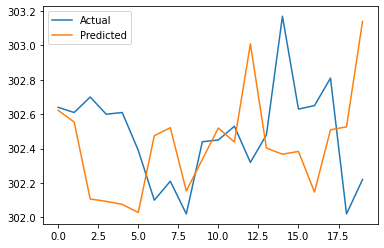

In [11]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 20)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Actual')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [12]:
# MSFT mean squared error
msft_rmse = np.sqrt(mean_squared_error(y, yhat))
print("RMSE: %f" % (msft_rmse))

RMSE: 0.443863


In [14]:
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)

In [15]:
# split into input and output columns
train_X, train_y = train[:, :-1], train[:, -1]

In [16]:
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [17]:
# construct an input for a new preduction
row = values[-6:]
row

[302.22, 302.23, 302.63, 302.6, 302.77, 302.65]

In [18]:
# make a one-step prediction
yhat_pred = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat_pred[0]))

Input: [302.22, 302.23, 302.63, 302.6, 302.77, 302.65], Predicted: 302.255


In [20]:
#Add MSFT Predictions to dataframe
#msft_signals=msft
#msft_signals["Predictions"]=yhat
#msft_signals

In [21]:
# create buy/sell signals
#msft_signals['Signal'] =0.0
#msft_signals.loc[(msft_signals['Predictions'] > msft_signals['Close']), 'Signal']=1
#msft_signals.loc[(msft_signals['Predictions'] < msft_signals['Close']), 'Signal']=-1
#msft_signals.to_csv("XGB-MSFT-Pred.csv")

In [22]:
# import ETH data
path=("ETH-USD_prices_5m_January.csv")
eth=pd.read_csv(path, index_col="Datetime", parse_dates=True, infer_datetime_format=True)
eth=eth.drop(columns=['Adj Close', 'Volume'])
eth

,Open,High,Low,Close
Datetime,,,,
2022-01-06 00:00:00+00:00,3545.65,3545.65,3536.39,3536.39
2022-01-06 00:05:00+00:00,3536.30,3538.52,3536.30,3538.47
2022-01-06 00:10:00+00:00,3538.58,3538.91,3535.28,3538.91
2022-01-06 00:15:00+00:00,3541.70,3546.87,3541.70,3546.87
2022-01-06 00:20:00+00:00,3544.46,3544.46,3531.40,3531.40
...,...,...,...,...
2022-01-26 00:45:00+00:00,2448.03,2448.03,2437.05,2437.05
2022-01-26 00:50:00+00:00,2436.73,2436.73,2432.26,2432.26
2022-01-26 00:55:00+00:00,2429.28,2429.28,2426.58,2427.48


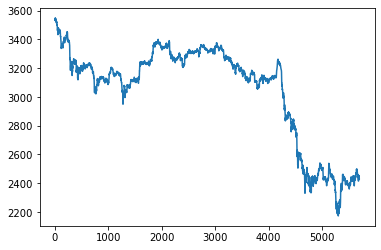

In [23]:
# load ETH dataset
eth_series = eth.Close
eth_values = eth_series.values
# plot ETH dataset to show trends
pyplot.plot(eth_values)
pyplot.show()

In [24]:
# transform ETH close prices
eth_values.reshape(-1, 1)
eth_values=eth_values.tolist()
eth_values

[3536.39,
 3538.47,
 3538.91,
 3546.87,
 3531.4,
 3534.06,
 3540.78,
 3546.69,
 3542.01,
 3540.03,
 3544.24,
 3546.51,
 3540.55,
 3535.53,
 3532.08,
 3540.63,
 3539.88,
 3535.56,
 3528.0,
 3529.55,
 3530.38,
 3529.38,
 3522.68,
 3525.25,
 3523.72,
 3530.46,
 3520.64,
 3517.92,
 3515.49,
 3513.53,
 3517.24,
 3516.55,
 3519.09,
 3519.69,
 3522.85,
 3517.67,
 3512.83,
 3510.95,
 3505.12,
 3501.24,
 3499.64,
 3502.8,
 3495.78,
 3498.36,
 3494.14,
 3484.59,
 3480.21,
 3471.11,
 3467.38,
 3459.68,
 3461.11,
 3474.28,
 3466.33,
 3464.43,
 3458.64,
 3445.83,
 3432.9,
 3436.61,
 3447.18,
 3457.53,
 3453.92,
 3464.21,
 3469.46,
 3473.64,
 3475.47,
 3478.62,
 3476.55,
 3477.42,
 3463.34,
 3462.24,
 3465.89,
 3469.37,
 3460.92,
 3456.64,
 3456.82,
 3467.17,
 3468.97,
 3469.23,
 3465.16,
 3457.81,
 3452.76,
 3446.52,
 3444.71,
 3449.86,
 3449.85,
 3459.91,
 3460.51,
 3461.23,
 3466.33,
 3467.24,
 3463.55,
 3461.94,
 3459.94,
 3457.66,
 3458.99,
 3462.99,
 3459.1,
 3457.07,
 3452.29,
 3452.7,
 3456.

In [25]:
# transform the time series data into supervised learning
eth_data = series_to_supervised(eth_values, n_in=6)

>actual=2423.5, predicted=2431.7
>actual=2418.4, predicted=2424.4
>actual=2417.9, predicted=2415.2
>actual=2414.8, predicted=2420.7
>actual=2416.8, predicted=2417.6
>actual=2416.3, predicted=2420.3
>actual=2452.9, predicted=2419.5
>actual=2450.8, predicted=2456.4
>actual=2453.7, predicted=2446.4
>actual=2447.1, predicted=2456.8
>actual=2444.9, predicted=2442.2
>actual=2445.3, predicted=2450.6
>actual=2447.2, predicted=2446.6
>actual=2451.0, predicted=2443.4
>actual=2448.8, predicted=2448.6
>actual=2437.1, predicted=2445.7
>actual=2432.3, predicted=2433.1
>actual=2427.5, predicted=2429.7
>actual=2427.5, predicted=2422.8
>actual=2427.4, predicted=2429.3
MAE: 5.926


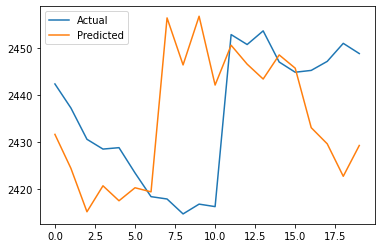

In [27]:
# evaluate
eth_mae, eth_y, eth_yhat = walk_forward_validation(eth_data, 20)
print('MAE: %.3f' % eth_mae)
# plot expected vs preducted
pyplot.plot(eth_y, label='Actual')
pyplot.plot(eth_yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [28]:
# mean squared error
eth_rmse = np.sqrt(mean_squared_error(eth_y, eth_yhat))
print("RMSE: %f" % (eth_rmse))

RMSE: 19.009053


In [29]:
# transform the time series data into supervised learning
eth_train = series_to_supervised(eth_values, n_in=6)

In [30]:
# split into input and output columns
eth_train_X, eth_train_y = eth_train[:, :-1], eth_train[:, -1]

In [31]:
# fit model
eth_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
eth_model.fit(eth_train_X, eth_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [32]:
# construct an input for a new preduction
eth_row = eth_values[-6:]
eth_row

[2448.85, 2437.05, 2432.26, 2427.48, 2427.53, 2427.45]

In [33]:
# make a one-step prediction
eth_yhat = eth_model.predict(asarray([eth_row]))
print('Input: %s, Predicted: %.3f' % (eth_row, eth_yhat[0]))

Input: [2448.85, 2437.05, 2432.26, 2427.48, 2427.53, 2427.45], Predicted: 2426.613


In [34]:
#Add predictions to ETH dataframe
eth_X_test1['Predictions']=eth_predictions
eth_preds=eth_X_test1
eth_preds

In [35]:
# add signals to ETH dataframe
eth_preds['Signal'] =0.0
eth_preds.loc[(eth_preds['Predictions'] > eth_preds['Close']), 'Signal']=1
eth_preds.loc[(eth_preds['Predictions'] < eth_preds['Close']), 'Signal']=-1
eth_preds.to_csv("XGB-ETH-Preds.csv")